In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

import tensorflow as tf
import tensorflow.keras.backend as k
from tensorflow.keras.layers import Activation
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
print("Num GPUs Available: ", 
      len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## 2.(a) Use CIFAR10

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [4]:
x_train.shape

(50000, 32, 32, 3)

## 2.(b) Extract bird class

In [5]:
# get the index of bird samples
bird_train_idx, _ = np.where(y_train == 2)
bird_test_idx, _ = np.where(y_test == 2)

# get samples
x_train_bird, y_train_bird = x_train[bird_train_idx], y_train[bird_train_idx]
x_test_bird, y_test_bird = x_test[bird_test_idx], y_test[bird_test_idx]

x_bird = np.concatenate([x_train_bird, x_test_bird])
y_bird = np.concatenate([y_train_bird, y_test_bird])

print(x_bird.shape)

(6000, 32, 32, 3)


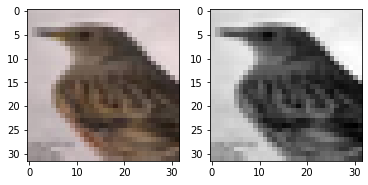

(32, 32)


In [6]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(x_bird[2])
axes[1].imshow(rgb2gray(x_bird[2]), cmap='gray')
plt.show()
print(rgb2gray(x_bird[2]).shape)

## 2.(c) Random select 80% pixels

In [7]:
pct = 0.8
numPix = x_bird.shape[0] * x_bird.shape[1] * x_bird.shape[2]
numRandom = int(numPix * pct)
print('Number of randomly-selected pixels: {}'.format(numRandom))
linearIdx = np.random.choice(numPix, numRandom)
imgIdx = [idx // 1024 for idx in linearIdx]
rowIdx = [idx % 1024 // 32 for idx in linearIdx]
colIdx = [idx % 1024 % 32 for idx in linearIdx]
pixIdx = (imgIdx, rowIdx, colIdx)
select_pix = x_bird[pixIdx]
print('Ndarray of selected pixels: ', select_pix.shape)
print(select_pix[:10])

Number of randomly-selected pixels: 4915200
Ndarray of selected pixels:  (4915200, 3)
[[137 161 109]
 [ 35  54  55]
 [117 132 153]
 [110 126 148]
 [136 140 116]
 [125 138 133]
 [136 136 136]
 [ 88  79  48]
 [153 134  99]
 [152 130  89]]


## 2.(d) Run k-means clustering on those color or use 4 suggested colors

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(select_pix) 
cluscenter = kmeans.cluster_centers_.astype(np.uint8())
cluscenter

array([[206, 211, 211],
       [ 49,  50,  38],
       [156, 155, 135],
       [109, 108,  82]], dtype=uint8)

In [9]:
# set cluster center to suggested colors
kmeans.cluster_centers_ = np.array([[0,0,128],
                                    [230,25,75],
                                    [170,255,195],
                                    [55,255,255]])

kcolor_birds = x_bird.reshape((-1, 3))
print(kcolor_birds.shape)

color_idx = kmeans.predict(kcolor_birds)
for i in range(kcolor_birds.shape[0]):
  kcolor_birds[i] = np.copy(kmeans.cluster_centers_[color_idx[i]])

kcolor_birds = np.reshape(kcolor_birds, x_bird.shape)
print(kcolor_birds.shape)

(6144000, 3)
(6000, 32, 32, 3)


## 2.(e) Obtain grayscale 32 × 32 × 1 images from the original 32 × 32 × 3 images

In [10]:
gray_birds = np.expand_dims(rgb2gray(x_bird), axis=-1)

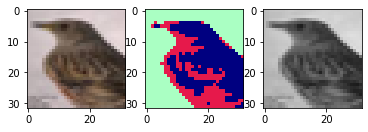

In [11]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(x_bird[2])
axes[1].imshow(kcolor_birds[2])
axes[2].imshow(np.stack((gray_birds[2, :, :, 0], ) * 3, axis=-1), cmap='gray')
plt.show()

## 2.(f) Set up a deep convolutional neural network with two convolution layers (or more) and two (or more) MLP layers.

In [12]:
from keras.utils import np_utils
# data preprocessing: split and normalize
num_train = 4800
cnn_train_x = gray_birds[:num_train]
cnn_test_x = gray_birds[num_train:]
cnn_train_x /= 255
cnn_test_x /= 255

color_onehot = np_utils.to_categorical(color_idx)
print(color_onehot.shape)
print(color_onehot[:10])
color_onehot = color_onehot.reshape((6000, 4096))
cnn_train_y = color_onehot[:num_train].reshape((-1, 4096))
cnn_test_y = color_onehot[num_train:].reshape((-1, 4096))

(6144000, 4)
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [26]:
def myCNN():
  model = Sequential()
  # convolutional layers
  model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', 
                   input_shape=(32,32,1), activation='relu',
                   kernel_initializer='he_normal'))
  model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', 
                   activation='relu', kernel_initializer='he_normal'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', 
                   activation='relu', kernel_initializer='he_normal'))
  model.add(MaxPooling2D(pool_size=(2, 2)))    
  model.add(Dropout(0.25))
  # MLP layers
  model.add(Flatten())
  model.add(Dense(8192, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation='relu'))
  model.add(Activation('softmax'))
  return model

In [34]:
model = myCNN()

In [35]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 8, 8, 64)         

In [36]:
# set optimization and callbacks
from keras.callbacks import Callback
test_loss = []
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
      # record a test loss
        scores = self.model.evaluate(cnn_test_x, cnn_test_y, verbose=1)
        test_loss.append(scores)
        checkpointer = ModelCheckpoint(filepath='CNNcheckpoints\weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                                       monitor='val_loss', mode='min', 
                                       verbose=0, save_best_only=True)

In [37]:
# fit the model
model.compile(loss='binary_crossentropy', optimizer='adam')
feeding = model.fit(cnn_train_x, cnn_train_y, 
                    validation_split=0.2, batch_size=32, 
                    epochs=30, verbose=1, callbacks=[MyCallback()])

Epoch 1/30
120/120 [==============================] - 3s 22ms/step - loss: 2.0070 - val_loss: 1.9620
Epoch 2/30
120/120 [==============================] - 2s 20ms/step - loss: 1.9540 - val_loss: 1.9467
Epoch 3/30
120/120 [==============================] - 2s 20ms/step - loss: 1.9389 - val_loss: 1.9340
Epoch 4/30
120/120 [==============================] - 2s 20ms/step - loss: 1.9315 - val_loss: 1.9324
Epoch 5/30
120/120 [==============================] - 2s 21ms/step - loss: 1.9245 - val_loss: 1.9227
Epoch 6/30
120/120 [==============================] - 2s 20ms/step - loss: 1.9200 - val_loss: 1.9215
Epoch 7/30
120/120 [==============================] - 2s 21ms/step - loss: 1.9161 - val_loss: 1.9173
Epoch 8/30
120/120 [==============================] - 2s 21ms/step - loss: 1.9124 - val_loss: 1.9175
Epoch 9/30
120/120 [==============================] - 2s 21ms/step - loss: 1.9097 - val_loss: 1.9117
Epoch 10/30
120/120 [==============================] - 3s 21ms/step - loss: 1.9043 - val_lo

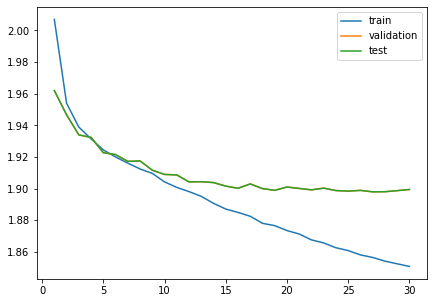

In [38]:
# plot loss curves
epoch = 30
train_loss = feeding.history['loss']
valid_loss = feeding.history['val_loss']

fig, axes = plt.subplots(figsize=(7, 5))
axes.plot(range(1, epoch + 1), train_loss, label='train')
axes.plot(range(1, epoch + 1), valid_loss, label='validation')
axes.plot(range(1, epoch + 1), test_loss, label='test')
axes.legend()
plt.show()

In [39]:
cnn_predict_y = model.predict(cnn_test_x[:10])
cnn_predict_y = np.reshape(cnn_predict_y, (10, 32, 32, 4))
cnn_predict_y = np.argmax(cnn_predict_y, axis=-1)
cnn_predict_y = kmeans.cluster_centers_[cnn_predict_y]
print(cnn_predict_y.shape)

(10, 32, 32, 3)


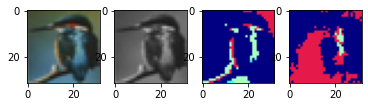

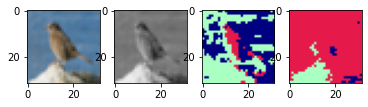

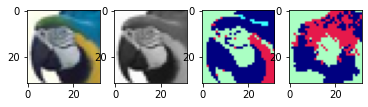

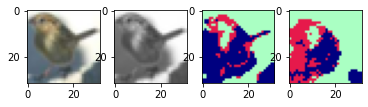

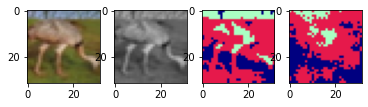

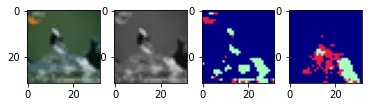

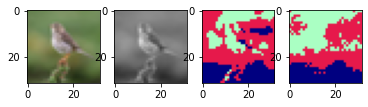

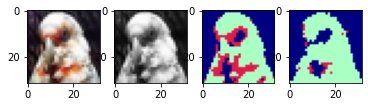

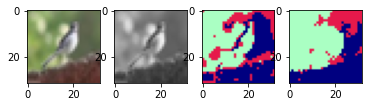

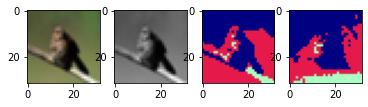

In [40]:
for i in range(10):
  fig, axes = plt.subplots(1, 4)
  axes[0].imshow(x_bird[num_train+i])
  axes[1].imshow(np.stack((gray_birds[num_train+i, :, :, 0] * 255, ) * 3, axis=-1), cmap='gray')
  axes[2].imshow(kcolor_birds[num_train+i])
  axes[3].imshow(cnn_predict_y[i])
  plt.show()